In [6]:
import networkx as nx
import numpy as np
import random
from scipy.optimize import linprog

# -------------------------------------
# LP-Relaxation Solver using SciPy linprog (corrected constraint)
# -------------------------------------
def solve_lp_relaxation(G: nx.Graph, D: set, k: int):
    nodes = list(G.nodes())
    n = len(nodes)
    edges = list(G.edges())
    m = len(edges)

    idx_s = {nodes[i]: i for i in range(n)}
    idx_z = {edges[j]: n + j for j in range(m)}

    # Bounds
    bounds = [(0,1)] * (n + m)
    for u in D:
        bounds[idx_s[u]] = (1,1)

    # Equality: sum s_i = k
    A_eq = np.zeros((1, n + m))
    for u in nodes:
        A_eq[0, idx_s[u]] = 1
    b_eq = [k]

    # Inequalities
    A_ub = []
    b_ub = []
    for (u, v) in edges:
        iu, iv = idx_s[u], idx_s[v]
        iz = idx_z[(u,v)]
        # z <= 1 - s_u  ->  s_u + z <= 1
        row = np.zeros(n + m)
        row[iu] = 1; row[iz] = 1
        A_ub.append(row); b_ub.append(1)
        # z <= 1 - s_v  ->  s_v + z <= 1
        row = np.zeros(n + m)
        row[iv] = 1; row[iz] = 1
        A_ub.append(row); b_ub.append(1)
        # z >= 1 - s_u - s_v  ->  -z - s_u - s_v <= -1
        row = np.zeros(n + m)
        row[iz] = -1; row[iu] = -1; row[iv] = -1
        A_ub.append(row); b_ub.append(-1)

    A_ub = np.array(A_ub)
    b_ub = np.array(b_ub)

    # Objective
    c = np.zeros(n + m)
    for j, (u, v) in enumerate(edges):
        c[n + j] = G.edges[u,v]['p']

    res = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq,
                  bounds=bounds, method='highs')
    if not res.success:
        raise RuntimeError("LP infeasible: " + res.message)

    return {nodes[i]: float(res.x[idx_s[nodes[i]]]) for i in range(n)}

# -------------------------------------
# Quick REGA-LP demo
# -------------------------------------
def REGA_with_LP(G, k, T_inner=100, R=3, alpha=0.2):
    def sample_avg(S):
        total = 0
        for _ in range(T_inner):
            H = nx.Graph(); H.add_nodes_from(G.nodes())
            for u, v in G.edges():
                if random.random() < G.edges[u,v]['p']:
                    H.add_edge(u,v)
            H.remove_nodes_from(S)
            total += sum(len(c)*(len(c)-1)/2 for c in nx.connected_components(H))
        return total / T_inner

    best_S, best_obj = None, float('inf')
    nodes = set(G.nodes())

    for _ in range(R):
        D = set()
        for _ in range(k):
            s_vals = solve_lp_relaxation(G, D, k)
            rem = list(nodes - D)
            sorted_nodes = sorted(rem, key=lambda u: s_vals[u], reverse=True)
            m = max(1, int(alpha * len(sorted_nodes)))
            D.add(random.choice(sorted_nodes[:m]))

        obj = sample_avg(D)
        improved = True
        while improved:
            improved = False
            for u in list(D):
                for v in nodes - D:
                    newS = (D - {u}) | {v}
                    val = sample_avg(newS)
                    if val < obj:
                        D, obj, improved = newS, val, True
                        break
                if improved:
                    break

        if obj < best_obj:
            best_S, best_obj = D.copy(), obj

    return best_S

# --- Sanity check on a small path graph ---
if __name__ == "__main__":
    G = nx.path_graph(4)
    for u,v in G.edges(): G.edges[u,v]['p'] = 0.5
    print("LP values (initial):", solve_lp_relaxation(G, set(), k=1))
    print("REGA-LP removal:", REGA_with_LP(G, k=1))


LP values (initial): {0: 0.0, 1: 1.0, 2: 0.0, 3: -0.0}
REGA-LP removal: {2}


In [8]:
import networkx as nx
import numpy as np
import random
from scipy.optimize import linprog
from tqdm import tqdm

# -------------------------------------
# LP-Relaxation Solver using SciPy linprog
# -------------------------------------
def solve_lp_relaxation(G: nx.Graph, D: set, k: int):
    nodes = list(G.nodes())
    n = len(nodes)
    edges = list(G.edges())
    m = len(edges)

    idx_s = {nodes[i]: i for i in range(n)}
    idx_z = {edges[j]: n + j for j in range(m)}

    # Bounds for variables
    bounds = [(0,1)] * (n + m)
    for u in D:
        bounds[idx_s[u]] = (1,1)

    # Equality: sum s_i = k
    A_eq = np.zeros((1, n + m))
    for u in nodes:
        A_eq[0, idx_s[u]] = 1
    b_eq = [k]

    # Inequality constraints
    A_ub, b_ub = [], []
    for (u, v) in edges:
        iu, iv = idx_s[u], idx_s[v]
        iz = idx_z[(u, v)]
        # z <= 1 - s_u  ->  s_u + z <= 1
        row = np.zeros(n + m); row[iu] = 1; row[iz] = 1
        A_ub.append(row); b_ub.append(1)
        # z <= 1 - s_v  ->  s_v + z <= 1
        row = np.zeros(n + m); row[iv] = 1; row[iz] = 1
        A_ub.append(row); b_ub.append(1)
        # z >= 1 - s_u - s_v  ->  -z - s_u - s_v <= -1
        row = np.zeros(n + m); row[iz] = -1; row[iu] = -1; row[iv] = -1
        A_ub.append(row); b_ub.append(-1)

    A_ub = np.array(A_ub)
    b_ub = np.array(b_ub)

    # Objective c
    c = np.zeros(n + m)
    for j, (u, v) in enumerate(edges):
        c[n + j] = G.edges[u, v]['p']

    res = linprog(c, A_ub=A_ub, b_ub=b_ub,
                  A_eq=A_eq, b_eq=b_eq,
                  bounds=bounds, method='highs')
    if not res.success:
        raise RuntimeError("LP infeasible: " + res.message)

    return {nodes[i]: float(res.x[idx_s[nodes[i]]]) for i in range(n)}

# -------------------------------------
# REGA with LP Relaxation
# -------------------------------------
def REGA_with_LP(G: nx.Graph, k: int, T_inner: int, R: int, alpha: float):
    def sample_avg(S):
        total = 0
        for _ in range(T_inner):
            H = nx.Graph(); H.add_nodes_from(G.nodes())
            for u, v in G.edges():
                if random.random() < G.edges[u, v]['p']:
                    H.add_edge(u, v)
            H.remove_nodes_from(S)
            total += sum(len(c)*(len(c)-1)/2 for c in nx.connected_components(H))
        return total / T_inner

    best_S, best_obj = None, float('inf')
    nodes = set(G.nodes())

    for _ in range(R):
        D = set()
        # Greedy build
        for _ in range(k):
            s_vals = solve_lp_relaxation(G, D, k)
            rem = list(nodes - D)
            sorted_nodes = sorted(rem, key=lambda u: s_vals[u], reverse=True)
            m = max(1, int(alpha * len(sorted_nodes)))
            D.add(random.choice(sorted_nodes[:m]))

        # Local search
        current_obj = sample_avg(D)
        improved = True
        while improved:
            improved = False
            for u in list(D):
                for v in nodes - D:
                    newS = (D - {u}) | {v}
                    val = sample_avg(newS)
                    if val < current_obj:
                        D, current_obj, improved = newS, val, True
                        break
                if improved:
                    break

        if current_obj < best_obj:
            best_obj, best_S = current_obj, D.copy()

    return best_S

# -------------------------------------
# Sample-average objective for final EPC
# -------------------------------------
def sample_average_objective(G: nx.Graph, S: set, T_eval: int):
    total = 0
    for _ in range(T_eval):
        H = nx.Graph(); H.add_nodes_from(G.nodes())
        for u, v in G.edges():
            if random.random() < G.edges[u, v]['p']:
                H.add_edge(u, v)
        H.remove_nodes_from(S)
        total += sum(len(c)*(len(c)-1)/2 for c in nx.connected_components(H))
    return total / T_eval

# ----- Sanity check on ER graph -----
# Base structure: n=20, m=50
G0 = nx.gnm_random_graph(50, 100, seed=42)

ps = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
k = 10
T_inner = 30
R = 2
alpha = 0.3
T_eval = 100

results = []
for p in tqdm(ps, desc="Running REGA-LP for different p values", total=len(ps)):
    G = G0.copy()
    for u, v in G.edges():
        G.edges[u, v]['p'] = p
    S_lp = REGA_with_LP(G, k, T_inner, R, alpha)
    epc_lp = sample_average_objective(G, S_lp, T_eval)
    results.append((p, S_lp, round(epc_lp,2)))

# Display results
import pandas as pd
df = pd.DataFrame(results, columns=["p","REGA-LP removal set","EPC_estimate"])


Running REGA-LP for different p values: 100%|██████████| 6/6 [00:39<00:00,  6.52s/it]


In [9]:
df

,p,REGA-LP removal set,EPC_estimate
0,0.1,"{2, 35, 34, 7, 14, 48, 17, 20, 27, 29}",5.47
1,0.3,"{34, 38, 40, 10, 13, 14, 48, 17, 20, 24}",27.82
2,0.5,"{5, 38, 7, 9, 10, 41, 14, 47, 46, 17}",75.16
3,0.7,"{5, 38, 7, 41, 10, 9, 14, 47, 17, 20}",183.75
4,0.9,"{5, 38, 7, 6, 41, 10, 14, 17, 20, 29}",238.22
5,1.0,"{5, 38, 7, 40, 10, 44, 14, 47, 17, 20}",274.00


In [10]:
import networkx as nx
import numpy as np
import random
import time
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import linprog
from tqdm import tqdm

# ----- Core Sampling and Estimation -----
def sample_realization(G: nx.Graph) -> nx.Graph:
    H = nx.Graph()
    H.add_nodes_from(G.nodes())
    for u, v in G.edges():
        if random.random() < G.edges[u, v]['p']:
            H.add_edge(u, v)
    return H

def pairwise_connectivity(H: nx.Graph) -> float:
    return sum(len(c) * (len(c) - 1) / 2 for c in nx.connected_components(H))

def estimate_epc(G: nx.Graph, N: int) -> float:
    n = G.number_of_nodes()
    total = 0.0
    for _ in range(N):
        u = random.choice(list(G.nodes()))
        visited = {u}
        queue = [u]
        while queue:
            v = queue.pop(0)
            for w in G.neighbors(v):
                if w not in visited and random.random() < G.edges[v, w]['p']:
                    visited.add(w)
                    queue.append(w)
        total += (len(visited) - 1)
    return (n * total) / (2 * N)

# ----- Heuristic Removals -----
def remove_k_betweenness(G: nx.Graph, k: int) -> nx.Graph:
    bc = nx.betweenness_centrality(G)
    topk = sorted(bc, key=bc.get, reverse=True)[:k]
    H = G.copy()
    H.remove_nodes_from(topk)
    return H

def remove_k_pagerank_edges(G: nx.Graph, k: int) -> nx.Graph:
    L = nx.line_graph(G)
    pr = nx.pagerank(L)
    topk = sorted(pr, key=pr.get, reverse=True)[:k]
    H = G.copy()
    H.remove_edges_from(topk)
    return H

# ----- Sample-Average Approximation (SAA) -----
def sample_average_objective(G: nx.Graph, S: set, T: int) -> float:
    total = 0.0
    for _ in range(T):
        H = sample_realization(G)
        H.remove_nodes_from(S)
        total += pairwise_connectivity(H)
    return total / T

def greedy_initial_SAA(G: nx.Graph, k: int, T: int) -> set:
    S = set()
    candidates = set(G.nodes())
    for _ in range(k):
        best_node, best_obj = None, float('inf')
        for u in candidates:
            obj = sample_average_objective(G, S | {u}, T)
            if obj < best_obj:
                best_node, best_obj = u, obj
        S.add(best_node)
        candidates.remove(best_node)
    return S

def SAA(G: nx.Graph, k: int, T: int) -> set:
    S = greedy_initial_SAA(G, k, T)
    improved = True
    while improved:
        improved = False
        current_obj = sample_average_objective(G, S, T)
        for u in list(S):
            for v in set(G.nodes()) - S:
                newS = (S - {u}) | {v}
                new_obj = sample_average_objective(G, newS, T)
                if new_obj < current_obj:
                    S, improved, current_obj = newS, True, new_obj
                    break
            if improved:
                break
    return S

# ----- LP Relaxation for REGA -----
def solve_lp_relaxation(G: nx.Graph, D: set, k: int) -> dict:
    nodes = list(G.nodes())
    n = len(nodes)
    edges = list(G.edges())
    m = len(edges)

    idx_s = {nodes[i]: i for i in range(n)}
    idx_z = {edges[j]: n + j for j in range(m)}

    bounds = [(0,1)] * (n + m)
    for u in D:
        bounds[idx_s[u]] = (1,1)

    A_eq = np.zeros((1, n + m))
    for u in nodes:
        A_eq[0, idx_s[u]] = 1
    b_eq = [k]

    A_ub, b_ub = [], []
    for (u, v) in edges:
        iu, iv = idx_s[u], idx_s[v]
        iz = idx_z[(u, v)]
        row = np.zeros(n + m); row[iu] = 1; row[iz] = 1
        A_ub.append(row); b_ub.append(1)
        row = np.zeros(n + m); row[iv] = 1; row[iz] = 1
        A_ub.append(row); b_ub.append(1)
        row = np.zeros(n + m); row[iz] = -1; row[iu] = -1; row[iv] = -1
        A_ub.append(row); b_ub.append(-1)
    A_ub = np.array(A_ub); b_ub = np.array(b_ub)

    c = np.zeros(n + m)
    for j, (u, v) in enumerate(edges):
        c[n + j] = G.edges[u, v]['p']

    res = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq,
                  bounds=bounds, method='highs')
    if not res.success:
        raise RuntimeError("LP infeasible: " + res.message)
    return {nodes[i]: float(res.x[idx_s[nodes[i]]]) for i in range(n)}

def REGA_with_LP(G: nx.Graph, k: int, T_inner: int, R: int, alpha: float) -> set:
    def sample_avg(S):
        total = 0.0
        for _ in range(T_inner):
            H = sample_realization(G)
            H.remove_nodes_from(S)
            total += pairwise_connectivity(H)
        return total / T_inner

    best_S, best_obj = None, float('inf')
    nodes = set(G.nodes())

    for _ in range(R):
        D = set()
        for _ in range(k):
            s_vals = solve_lp_relaxation(G, D, k)
            rem = list(nodes - D)
            sorted_nodes = sorted(rem, key=lambda u: s_vals[u], reverse=True)
            m = max(1, int(alpha * len(sorted_nodes)))
            D.add(random.choice(sorted_nodes[:m]))
        current_obj = sample_avg(D)
        improved = True
        while improved:
            improved = False
            for u in list(D):
                for v in nodes - D:
                    newS = (D - {u}) | {v}
                    val = sample_avg(newS)
                    if val < current_obj:
                        D, current_obj, improved = newS, val, True
                        break
                if improved:
                    break
        if current_obj < best_obj:
            best_S, best_obj = D.copy(), current_obj
    return best_S

# ----- Experiment Runner including ALL algorithms -----
def run_experiments(models, ps, k,
                    T_saa, T_inner_rega, R_rega, alpha_rega, N_eval):
    records = []
    for name, G0 in tqdm(models.items(), desc="Running experiments", total=len(models)):
        for p in tqdm(ps, desc=f"Model {name} with p", total=len(ps)):
            G = G0.copy()
            for u, v in G.edges():
                G.edges[u, v]['p'] = p

            # Betweenness
            t0 = time.perf_counter()
            G_bc = remove_k_betweenness(G, k)
            t_bc = time.perf_counter() - t0

            epc_bc = estimate_epc(G_bc, N_eval)

            # PageRank
            t0 = time.perf_counter()
            G_pr = remove_k_pagerank_edges(G, k)
            t_pr = time.perf_counter() - t0

            epc_pr = estimate_epc(G_pr, N_eval)

            #SAA
            t0 = time.perf_counter()
            S_saa = SAA(G, k, T_saa)
            t_saa = time.perf_counter() - t0

            G_saa = G.copy(); G_saa.remove_nodes_from(S_saa)
            epc_saa = estimate_epc(G_saa, N_eval)

            # REGA-LP
            t0 = time.perf_counter()
            S_rega = REGA_with_LP(G, k, T_inner_rega, R_rega, alpha_rega)
            t_rega = time.perf_counter() - t0

            G_rega = G.copy(); G_rega.remove_nodes_from(S_rega)
            epc_rega = estimate_epc(G_rega, N_eval)

            for algo, t, e in [
                ('Betweenness', t_bc, epc_bc),
                ('PageRank',    t_pr, epc_pr),
                ('SAA',         t_saa, epc_saa),
                ('REGA-LP',     t_rega, epc_rega)
            ]:
                records.append({
                    'model': name, 'p': p, 'algo': algo,
                    'time': t, 'epc': e
                })
    return pd.DataFrame(records)

Running experiments: 100%|██████████| 3/3 [38:29<00:00, 769.98s/it]


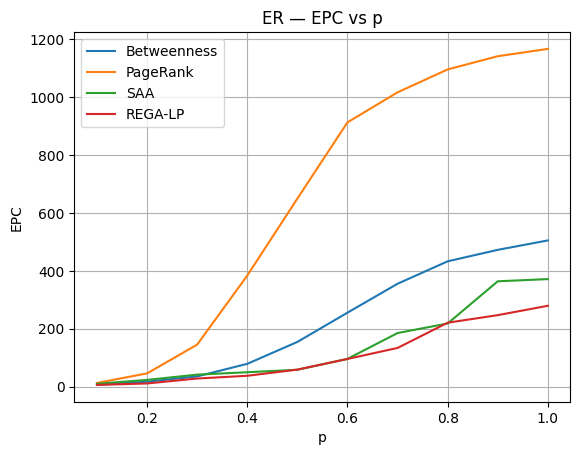

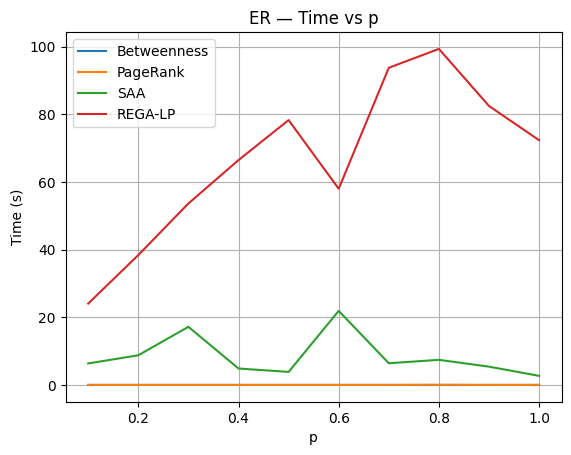

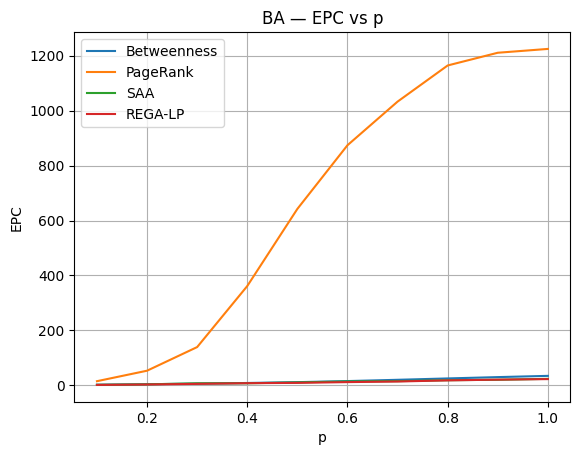

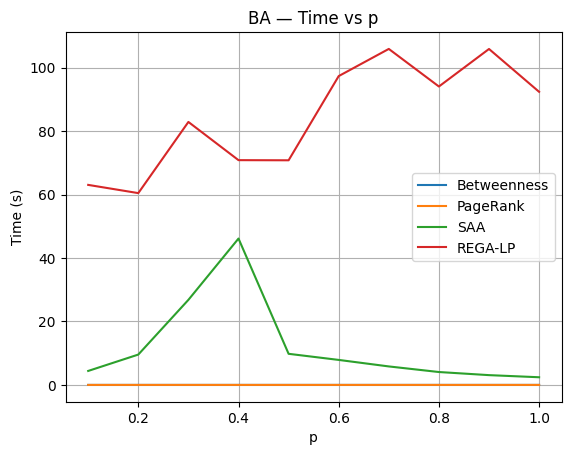

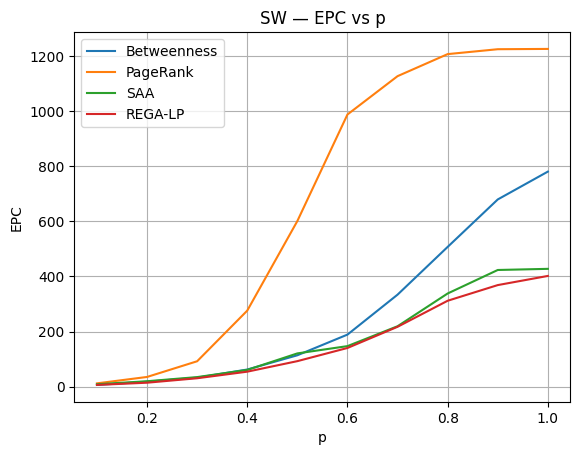

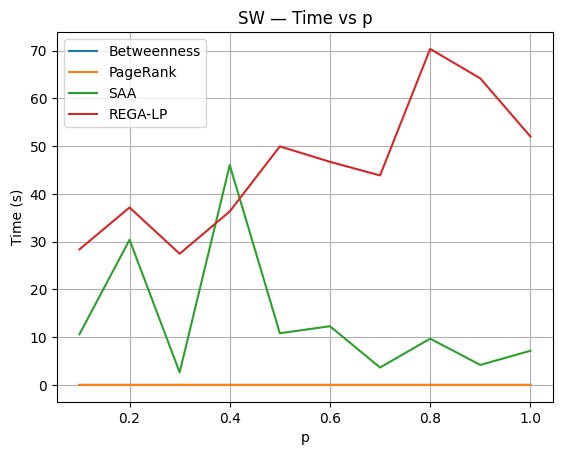

In [ ]:


# ----- Define models and parameters -----
models = {
    'ER': nx.gnm_random_graph(50, 100, seed=42),
    'BA': nx.barabasi_albert_graph(50, 2, seed=42),
    'SW': nx.watts_strogatz_graph(50, 4, 0.3, seed=42),
}

ps = np.arange(0.0, 1.2, 0.2)
k = 10
T_saa = 30
T_inner_rega = 1000    # inner-sample size for REGA
R_rega = 5            # restarts for REGA
alpha_rega = 0.2
N_eval = 10000         # final EPC sample count (use 1e5 for paper-quality)

# Execute experiments
df = run_experiments(models, ps, k, T_saa, T_inner_rega, R_rega, alpha_rega, N_eval)

# Plot EPC vs p and Time vs p
for name in models:
    plt.figure()
    for algo in df.algo.unique():
        sub = df[(df.model == name) & (df.algo == algo)]
        plt.plot(sub.p, sub.epc, label=algo)
    plt.title(f"{name} — EPC vs p")
    plt.xlabel("p"); plt.ylabel("EPC"); plt.grid(True); plt.legend()
    plt.savefig(f"{name}_epc_vs_p.png")

    plt.figure()
    for algo in df.algo.unique():
        sub = df[(df.model == name) & (df.algo == algo)]
        plt.plot(sub.p, sub.time, label=algo)
    plt.title(f"{name} — Time vs p")
    plt.xlabel("p"); plt.ylabel("Time (s)"); plt.grid(True); plt.legend()
    plt.savefig(f"{name}_time_vs_p.png")
plt.show()


In [4]:
df

,model,p,algo,time,epc
0,ER,0.1,Betweenness,0.002380,6.440
1,ER,0.1,PageRank,0.002188,12.775
2,ER,0.1,SAA,6.350675,9.860
3,ER,0.1,REGA-LP,24.046650,5.840
4,ER,0.2,Betweenness,0.002246,17.020
...,...,...,...,...,...
115,SW,0.9,REGA-LP,64.211692,368.400
116,SW,1.0,Betweenness,0.002345,780.000
117,SW,1.0,PageRank,0.001627,1225.000
118,SW,1.0,SAA,7.147936,427.320


In [11]:
import random, itertools, math, networkx as nx
import pandas as pd

# ---------- Helper functions ----------

def threshold_graph(G_prob, tau=0.5):
    """Return deterministic skeleton keeping only edges whose 'prob' >= tau."""
    G = nx.Graph()
    G.add_nodes_from(G_prob.nodes())
    for u, v, data in G_prob.edges(data=True):
        if data["prob"] >= tau:
            G.add_edge(u, v)
    return G

def greedy_mis(G):
    """Simple degree-ascending greedy maximal independent set."""
    mis = set()
    for v in sorted(G.nodes(), key=G.degree):
        if all(n not in mis for n in G.neighbors(v)):
            mis.add(v)
    return mis

def pairwise_cost_det(G):
    """Deterministic connectivity cost Σ σ(σ-1)/2 over components."""
    cost = 0
    for comp in nx.connected_components(G):
        s = len(comp)
        cost += s*(s-1)//2
    return cost

def arulselvan_cndp(G_det, k):
    """Return deletion set of size k using MIS + greedy augmentation."""
    mis = greedy_mis(G_det)
    # Greedy augmentation
    while len(mis) != G_det.number_of_nodes() - k:
        best_phi, best_v = math.inf, None
        for v in set(G_det.nodes()) - mis:
            # compute phi if we keep v (delete others)
            temp_keep = mis | {v}
            H = G_det.subgraph(temp_keep)
            phi = pairwise_cost_det(H)
            if phi < best_phi:
                best_phi, best_v = phi, v
        mis.add(best_v)
    deletion_set = set(G_det.nodes()) - mis
    return deletion_set

def expected_pairwise_cost(G_prob, removed_nodes=None, T=200, seed=0):
    """Monte Carlo estimate of expected pairwise connectivity after removing nodes."""
    if removed_nodes is None:
        removed_nodes = set()
    rng = random.Random(seed)
    nodes_kept = [n for n in G_prob.nodes() if n not in removed_nodes]
    if not nodes_kept:   # no nodes remain
        return 0.0
    acc = 0.0
    edges_with_prob = [(u, v, data["prob"]) for u, v, data in G_prob.edges(data=True)]
    for _ in range(T):
        Gs = nx.Graph()
        Gs.add_nodes_from(nodes_kept)
        for u, v, p in edges_with_prob:
            if u in removed_nodes or v in removed_nodes:
                continue
            if rng.random() < p:
                Gs.add_edge(u, v)
        acc += pairwise_cost_det(Gs)
    return acc / T

# ---------- 1. Toy Example (6 nodes) -------------

# manual edge list with probabilities
toy_edges = [
    (1, 2, 0.80),
    (1, 3, 0.48),
    (2, 3, 0.70),
    (2, 4, 0.25),
    (3, 4, 0.60),
    (3, 5, 0.30),
    (4, 5, 0.65),
    (4, 6, 0.90),
    (5, 6, 0.35),
]
G_toy_prob = nx.Graph()
G_toy_prob.add_nodes_from(range(1, 7))
for u, v, p in toy_edges:
    G_toy_prob.add_edge(u, v, prob=p)

tau = 0.5
k_toy = 2
G_toy_det = threshold_graph(G_toy_prob, tau)
del_toy = arulselvan_cndp(G_toy_det, k_toy)

epc_before_toy = expected_pairwise_cost(G_toy_prob, removed_nodes=set(), T=500, seed=42)
epc_after_toy  = expected_pairwise_cost(G_toy_prob, removed_nodes=del_toy, T=500, seed=42)

# ---------- 2. Medium Example (100 nodes, 200 edges) -------------

random.seed(1)
n, m, k_medium = 50, 100, 15
G_med_det_base = nx.gnm_random_graph(n, m, seed=2)  # deterministic backbone

# assign heterogeneous per-edge reliability ~ Uniform[0.1,1]
G_med_prob = nx.Graph()
G_med_prob.add_nodes_from(G_med_det_base.nodes())
for u, v in G_med_det_base.edges():
    G_med_prob.add_edge(u, v, prob=random.uniform(0.1, 1.0))

tau_med = 0.5
G_med_det = threshold_graph(G_med_prob, tau_med)
del_med = arulselvan_cndp(G_med_det, k_medium)

epc_before_med = expected_pairwise_cost(G_med_prob, set(), T=200, seed=24)
epc_after_med  = expected_pairwise_cost(G_med_prob, del_med, T=200, seed=24)

# ---------- Summaries -------------

summary_toy = {
    "Example": ["Toy (n=6)"],
    "Threshold τ": [tau],
    "k deletions": [k_toy],
    "Deletion set": [sorted(del_toy)],
    "EPC before": [round(epc_before_toy, 2)],
    "EPC after": [round(epc_after_toy, 2)]
}

summary_med = {
    "Example": ["Medium (n=100)"],
    "Threshold τ": [tau_med],
    "k deletions": [k_medium],
    "Deletion set": [sorted(del_med)[:5] + ["..."]],  # truncate for display
    "EPC before": [round(epc_before_med, 1)],
    "EPC after": [round(epc_after_med, 1)]
}

df = pd.concat([pd.DataFrame(summary_toy), pd.DataFrame(summary_med)], ignore_index=True)


In [12]:
df

,Example,Threshold τ,k deletions,Deletion set,EPC before,EPC after
0,Toy (n=6),0.5,2,"[2, 4]",10.87,1.42
1,Medium (n=100),0.5,15,"[3, 14, 15, 16, 23, ...]",973.90,36.60


In [13]:
def threshold_graph(G_prob, tau=0.5):
    """Return deterministic skeleton keeping only edges whose 'prob' >= tau."""
    G = nx.Graph()
    G.add_nodes_from(G_prob.nodes())
    for u, v, data in G_prob.edges(data=True):
        if data["prob"] >= tau:
            G.add_edge(u, v)
    return G

def greedy_mis(G):
    """Simple degree-ascending greedy maximal independent set."""
    mis = set()
    for v in sorted(G.nodes(), key=G.degree):
        if all(n not in mis for n in G.neighbors(v)):
            mis.add(v)
    return mis

def pairwise_cost_det(G):
    """Deterministic connectivity cost Σ σ(σ-1)/2 over components."""
    cost = 0
    for comp in nx.connected_components(G):
        s = len(comp)
        cost += s*(s-1)//2
    return cost

def arulselvan_cndp(G_det, k):
    """Return deletion set of size k using MIS + greedy augmentation."""
    mis = greedy_mis(G_det)
    # Greedy augmentation
    while len(mis) != G_det.number_of_nodes() - k:
        best_phi, best_v = math.inf, None
        for v in set(G_det.nodes()) - mis:
            # compute phi if we keep v (delete others)
            temp_keep = mis | {v}
            H = G_det.subgraph(temp_keep)
            phi = pairwise_cost_det(H)
            if phi < best_phi:
                best_phi, best_v = phi, v
        mis.add(best_v)
    deletion_set = set(G_det.nodes()) - mis
    return deletion_set

In [14]:
def run_experiments_with_threshold(models, ps, k,
                                   T_saa, T_rega, R_rega, alpha,
                                   tau, N_eval):
    records = []
    for name, G0 in tqdm(models.items(), desc="Running experiments", total=len(models)):
        for p in tqdm(ps, desc=f"Model {name} with p", total=len(ps)):
            # 1. build probabilistic graph
            G = G0.copy()
            nx.set_edge_attributes(G, {e: p for e in G.edges()}, 'p')

            # 2. Betweenness
            t0 = time.perf_counter()
            H_bc = remove_k_betweenness(G, k)
            t_bc = time.perf_counter() - t0
            epc_bc = estimate_epc(H_bc, N_eval)

            # 3. PageRank
            t0 = time.perf_counter()
            H_pr = remove_k_pagerank_edges(G, k)
            t_pr = time.perf_counter() - t0
            epc_pr = estimate_epc(H_pr, N_eval)

            # 4. SAA
            t0 = time.perf_counter()
            S_saa = SAA(G, k, T_saa)
            t_saa = time.perf_counter() - t0
            H_saa = G.copy(); H_saa.remove_nodes_from(S_saa)
            epc_saa = estimate_epc(H_saa, N_eval)

            # 5. REGA
            t0 = time.perf_counter()
            S_rega = REGA_with_LP(G, k, T_rega, R_rega, alpha)
            t_rega = time.perf_counter() - t0
            H_rega = G.copy(); H_rega.remove_nodes_from(S_rega)
            epc_rega = estimate_epc(H_rega, N_eval)

            # 6. Threshold + MIS (Arulselvan et al.)
            t0 = time.perf_counter()
            G_det = threshold_graph(G, tau)
            del_th = arulselvan_cndp(G_det, k)
            t_th = time.perf_counter() - t0
            H_th = G.copy(); H_th.remove_nodes_from(del_th)
            epc_th = estimate_epc(H_th, N_eval)

            # 7. collect records for all 5
            for algo, t, epc in [
                ('Betweenness', t_bc, epc_bc),
                ('PageRank',    t_pr, epc_pr),
                ('SAA',         t_saa, epc_saa),
                ('REGA',        t_rega, epc_rega),
                ('Thresh-MIS',  t_th,  epc_th),
            ]:
                records.append({
                    'model': name,
                    'p':      p,
                    'algo':   algo,
                    'time':   t,
                    'epc':    epc
                })
    return pd.DataFrame(records)

In [16]:
models = {
    'ER': nx.gnm_random_graph(20, 40, seed=42),
    'BA': nx.barabasi_albert_graph(20, 2, seed=42),
    'SW': nx.watts_strogatz_graph(20, 4, 0.3, seed=42),
}

df = run_experiments_with_threshold(
    models,
    ps=[0.1,0.2,0.5,0.7 ,1.0],
    k=10,
    T_saa=30,
    T_rega=1000,
    R_rega=5,
    alpha=0.2,
    tau=0.5,
    N_eval=10000
)

Running experiments:   0%|          | 0/3 [00:31<?, ?it/s]


KeyError: 'prob'

In [ ]:
for name in models:
    plt.figure()
    for algo in df.algo.unique():
        sub = df[(df.model == name) & (df.algo == algo)]
        plt.plot(sub.p, sub.epc, label=algo)
    plt.title(f"{name} — EPC vs p")
    plt.xlabel("p"); plt.ylabel("EPC"); plt.grid(True); plt.legend()
    plt.savefig(f"{name}_epc_vs_p.png")

    plt.figure()
    for algo in df.algo.unique():
        sub = df[(df.model == name) & (df.algo == algo)]
        plt.plot(sub.p, sub.time, label=algo)
    plt.title(f"{name} — Time vs p")
    plt.xlabel("p"); plt.ylabel("Time (s)"); plt.grid(True); plt.legend()
    plt.savefig(f"{name}_time_vs_p.png")
plt.show()